In [1]:
import cv2, sys, os, time
import numpy as np
import pickle
import matplotlib.pyplot as plt 

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

from utils.detection_tools import extract_object_and_background_masks
from utils.detection_tools import detect_sky, estimate_horizon_line_by_edges
from utils.detection_tools import rectify_horizon, downsampler, rotate_and_center_horizon
from utils.common_tools import annotate_image, show_bgr
from utils.common_tools import find_nonzero_bounding_box, trim_video, draw_parallel_lines

from utils.detection_tools import get_min_max_hsv, extract_contour_region
from auto_startup.config import ImageProcessingParams
from utils.detection_tools import detect_sky, estimate_horizon_line_by_edges
from utils.detection_tools import  downsampler, rotate_and_center_horizon
from utils.common_tools import annotate_image, show_bgr, draw_parallel_lines
from src.detect_basic import detect_basic




In [2]:
## Input 1: input pic of O & B
## Input 2: get live stream, get picture of O+B
## Input 3: input pic of O, get live stream of B
## Statement: There is one discrete target here. Find it. 
## get B col, O col, O size, location, pass option
##
## Process
##
##

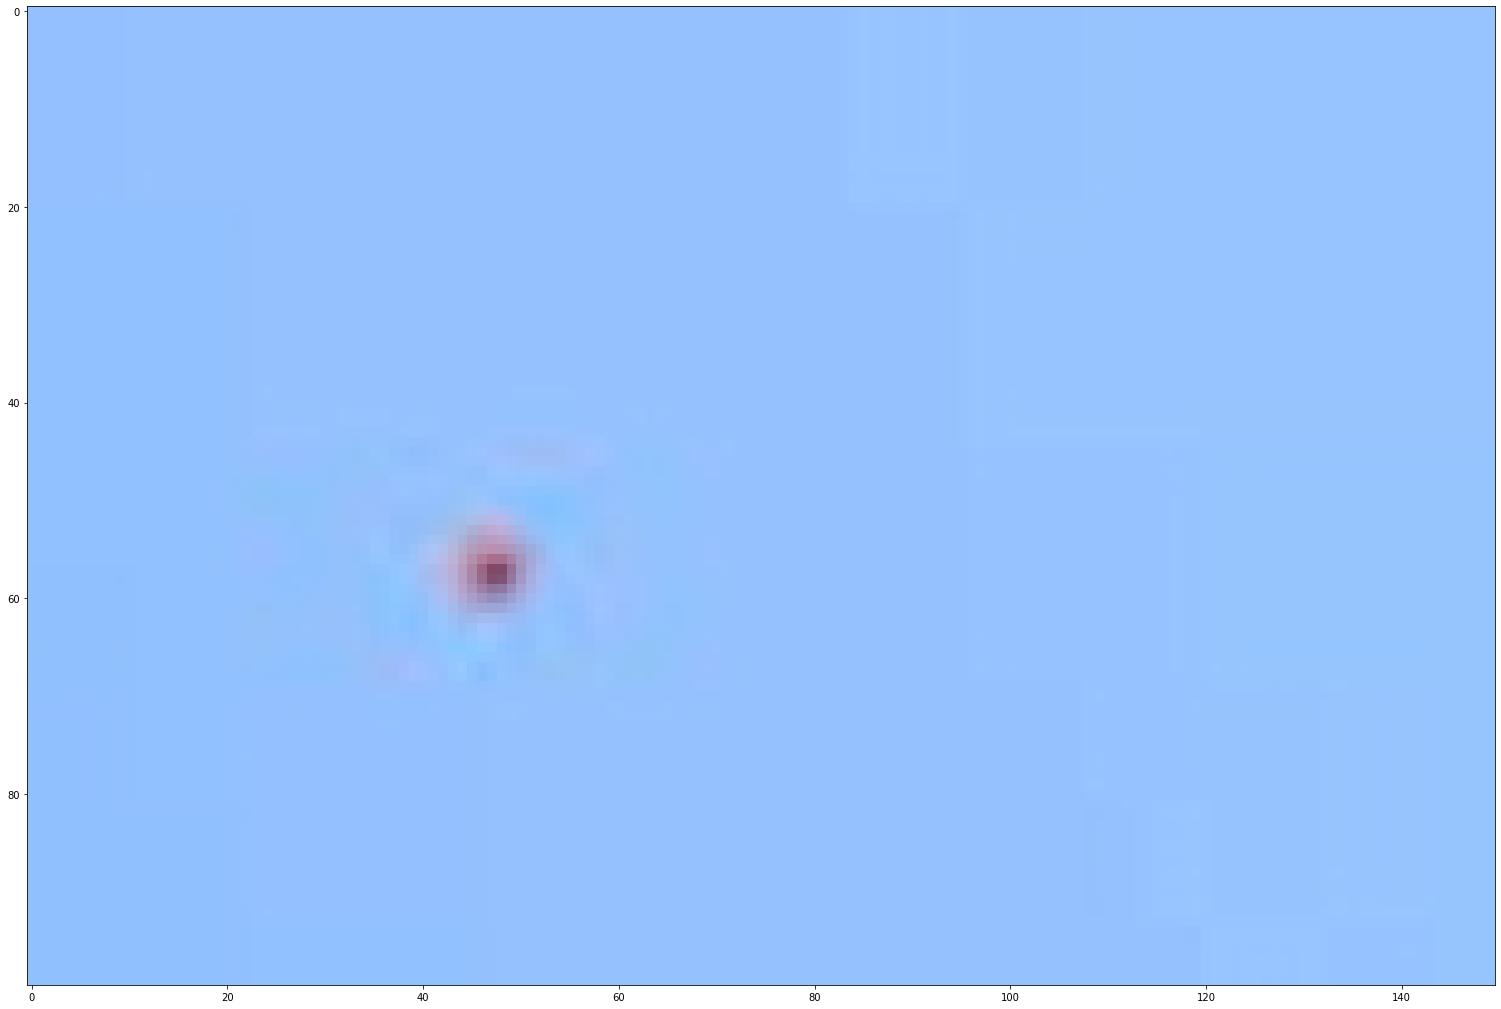

In [2]:
# load in foi_2.png with opencv

frame = cv2.imread('foi_2.png')
#frame = frame[125:175,150:250] #for foi_3
#frame = frame #for foi_3b
frame = frame[400:500,450:600] #for foi_2



show_bgr(frame,w=30)

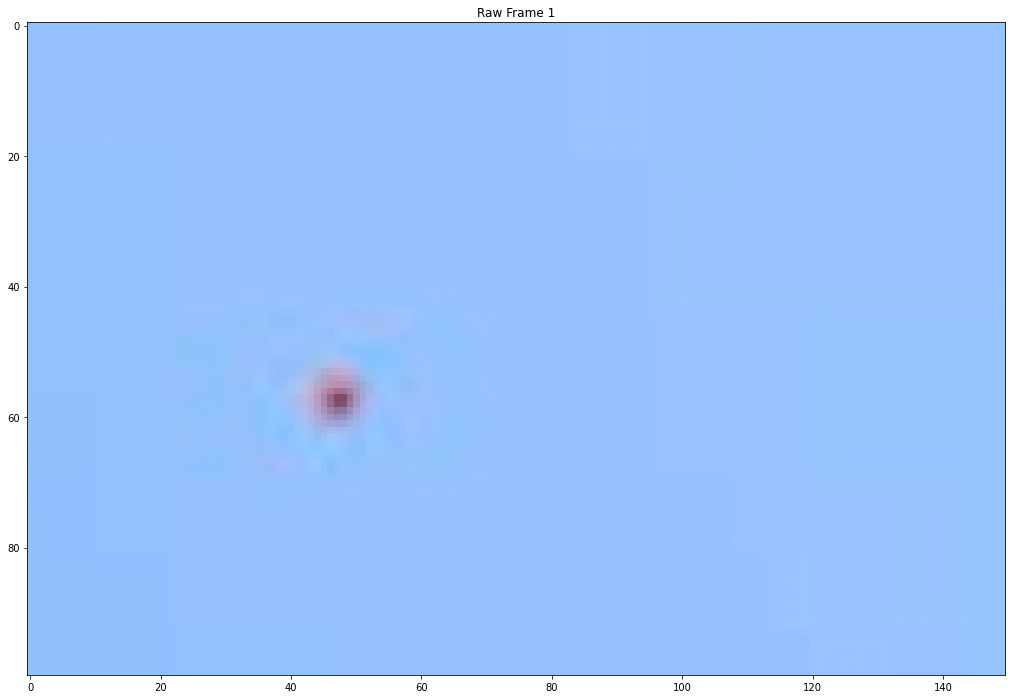

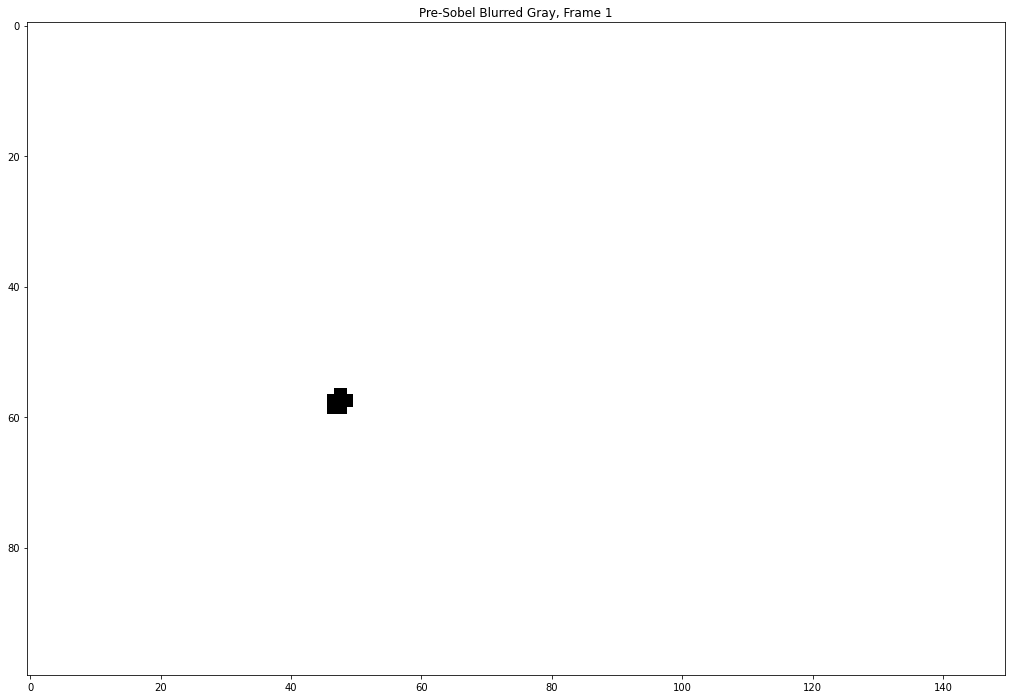

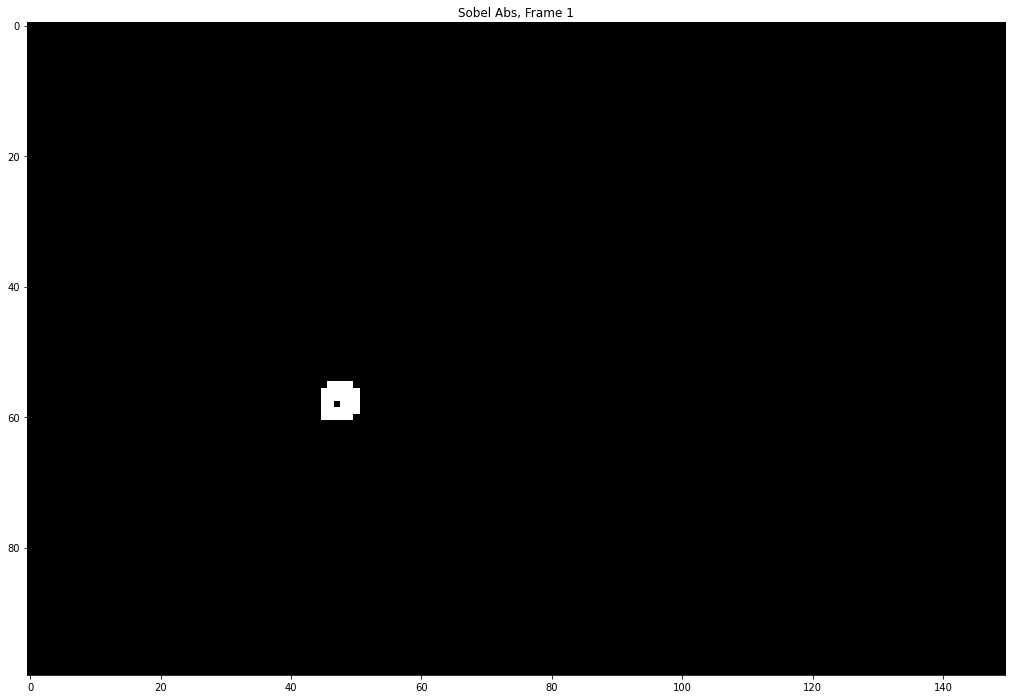

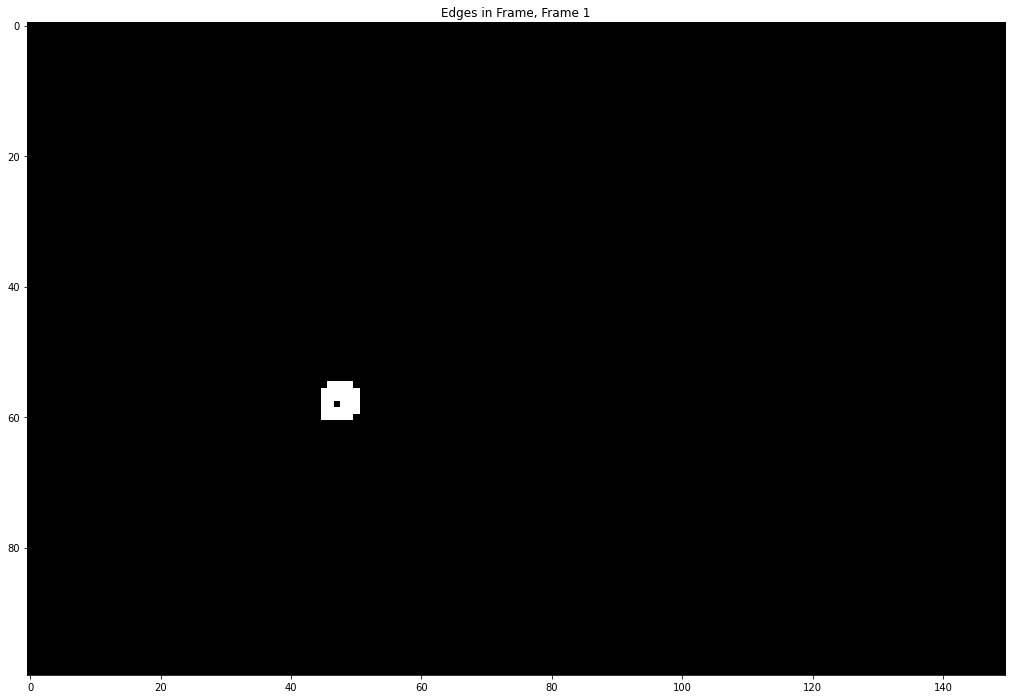

HSV Values
{'min_h': 117, 'max_h': 166, 'min_s': 46, 'max_s': 114, 'min_v': 126, 'max_v': 211}


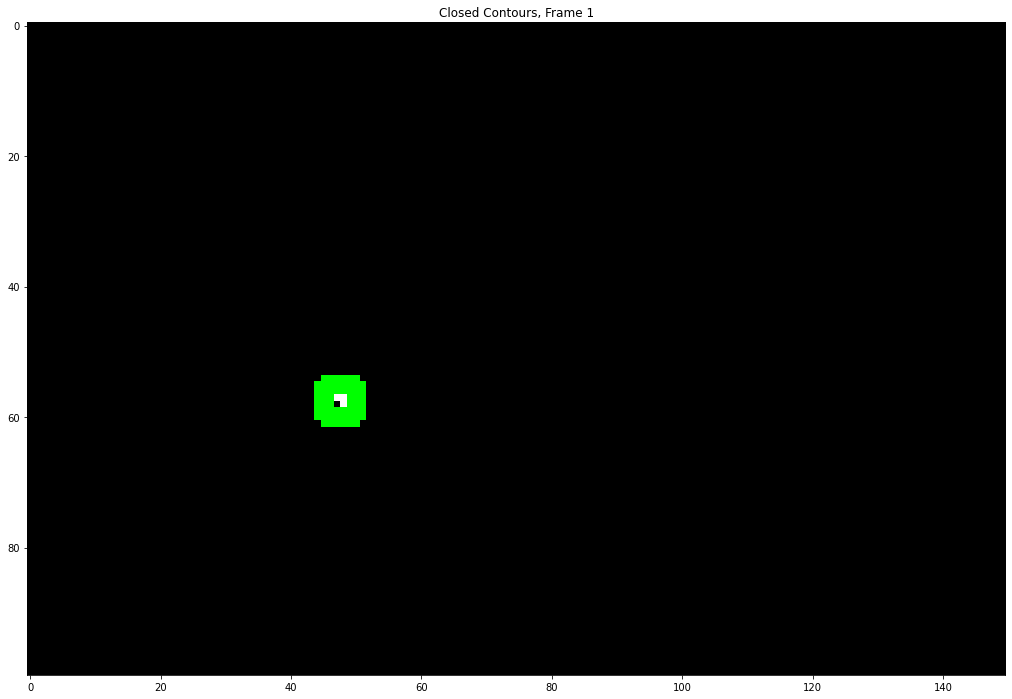

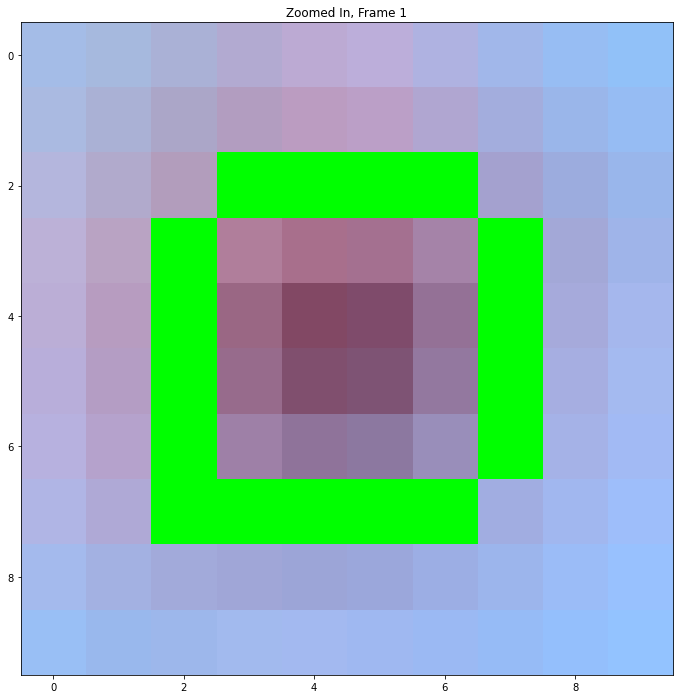

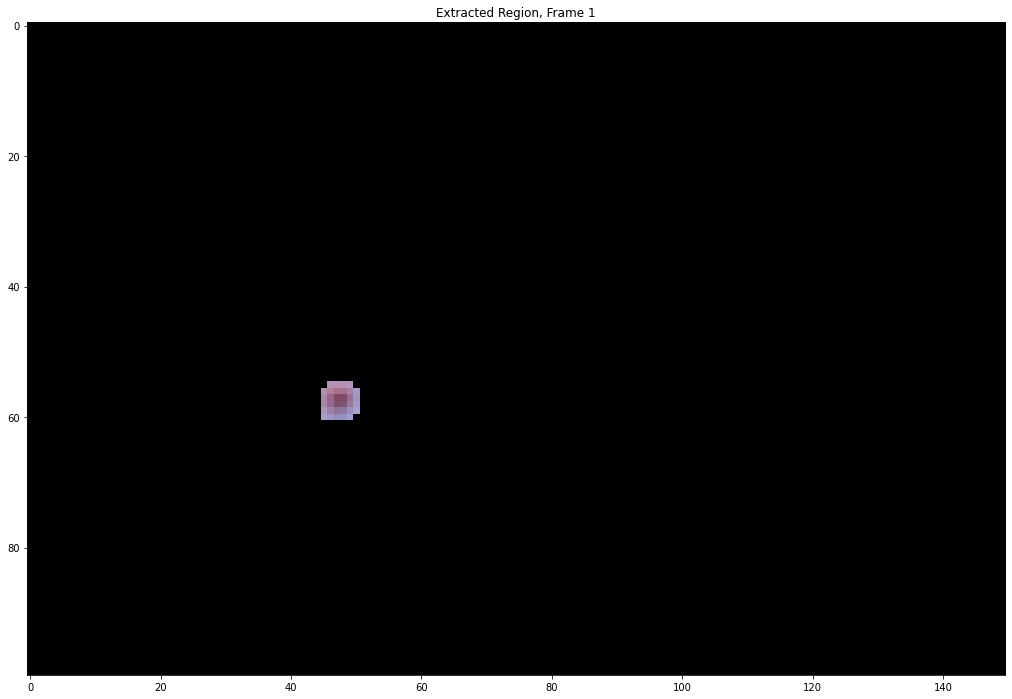

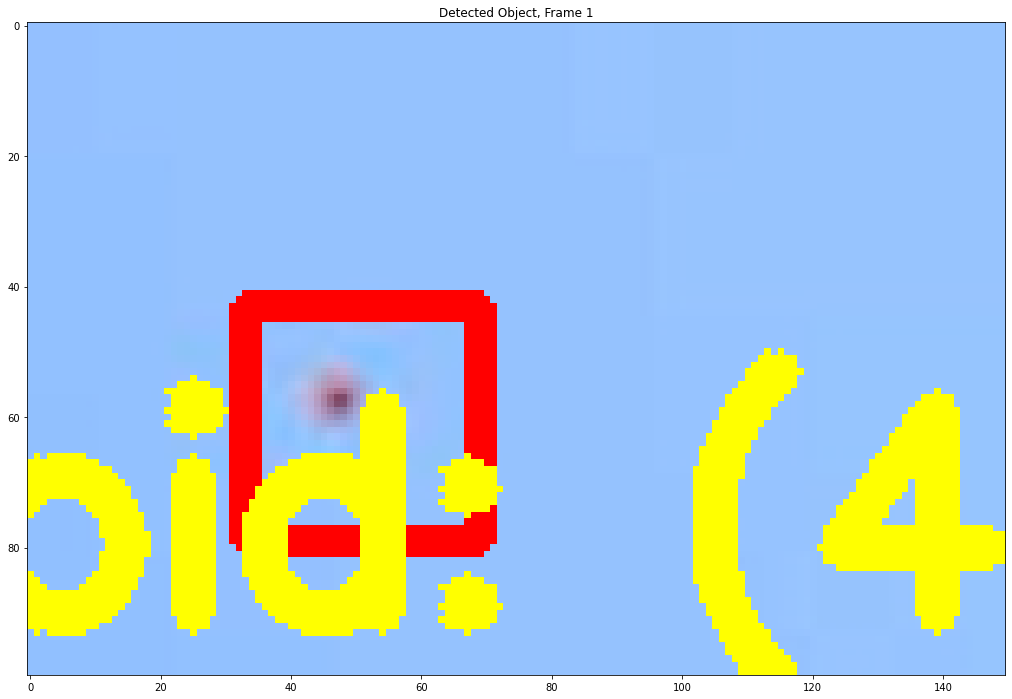

ValueError: too many values to unpack (expected 5)

In [3]:
complete_frame, x,y,w,h = detect_basic(frame,1,debug=True,debug_image_width=20)
 

[193.90662 129.42001  91.56739]
193.90662
174
213
129.42001
116
142
91.56739
82
100


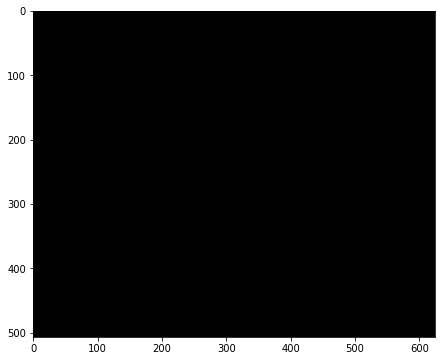

In [16]:
lab_colors = result['background_color_lab']
print(lab_colors)   
masked_frame = mask_pixels_within_lab_range(frame, lab_colors)
show_bgr(masked_frame,w=10)


In [14]:
# ========================================================
# Segmentation Routine (using k-means clustering)
# ========================================================
def segment_two_colors(frame, k=2):
    """
    Given a frame that has two dominant color regions, segment it using k-means clustering.
    Assumes that one cluster is the object (smaller area) and the other is the background.
    
    Returns a dictionary with:
      - object_mask, background_mask: binary masks for each region.
      - object_color_lab, background_color_lab: cluster centers in LAB color space.
      - object_color_bgr, background_color_bgr: cluster centers converted to BGR.
      - object_area, background_area: pixel counts for each cluster.
      - object_bbox: bounding box (x, y, w, h) for the object (largest contour in object mask).
    """
    # Convert image to LAB color space (LAB tends to be perceptually uniform)
    lab_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2LAB)
    show_bgr(lab_frame,w=10)    
    # Reshape into 2D array of pixels and convert to float32 for k-means.
    pixel_values = lab_frame.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)
    
    # Define k-means criteria and run clustering.
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    attempts = 10
    ret, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, attempts, cv2.KMEANS_RANDOM_CENTERS)
    
    # Reshape labels back to the image shape.
    labels = labels.flatten()
    segmented_img = labels.reshape(frame.shape[:2])
    
    # Determine the area (pixel count) of each cluster.
    unique, counts = np.unique(labels, return_counts=True)
    cluster_areas = dict(zip(unique, counts))
    
    # Assume that the background is the cluster with more pixels.
    background_index = max(cluster_areas, key=cluster_areas.get)
    object_index     = min(cluster_areas, key=cluster_areas.get)
    
    # Create binary masks.
    object_mask = np.uint8((segmented_img == object_index)) * 255
    background_mask = np.uint8((segmented_img == background_index)) * 255
    
    # Retrieve the cluster centers (in LAB).
    object_color_lab     = centers[object_index]
    background_color_lab = centers[background_index]
    
    # Convert LAB centers to BGR for easier visualization.
    object_color_bgr = cv2.cvtColor(np.uint8([[object_color_lab]]), cv2.COLOR_LAB2BGR)[0][0]
    background_color_bgr = cv2.cvtColor(np.uint8([[background_color_lab]]), cv2.COLOR_LAB2BGR)[0][0]
    
    # Compute a bounding box for the object based on its mask.
    contours, _ = cv2.findContours(object_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        object_bbox = cv2.boundingRect(largest_contour)
    else:
        object_bbox = None
    
    result = {
        'object_mask': object_mask,
        'background_mask': background_mask,
        'object_color_lab': object_color_lab,
        'background_color_lab': background_color_lab,
        'object_color_bgr': object_color_bgr,
        'background_color_bgr': background_color_bgr,
        'object_area': cluster_areas[object_index],
        'background_area': cluster_areas[background_index],
        'object_bbox': object_bbox
    }
    return result


def mask_pixels_within_lab_range(frame, lab_colors, tolerance=0.1):
    """
    Given an input frame (BGR) and a set of reference LAB colors, return a binary mask where
    each pixel is selected if its LAB value is within ±(tolerance*100)% of any of the reference colors.
    
    For each reference color, the tolerance is applied per channel. For example, if the reference
    LAB value is [L, a, b], then a pixel's LAB value [L_p, a_p, b_p] is considered close if:
      L_p is in [L*(1-tolerance), L*(1+tolerance)],
      a_p is in [a*(1-tolerance), a*(1+tolerance)], and
      b_p is in [b*(1-tolerance), b*(1+tolerance)].
    
    Parameters:
      frame (numpy.ndarray): Input image in BGR format.
      lab_colors (list or tuple): A list of reference LAB colors. Each color should be an iterable
                                  of three values (L, a, b). The values should be in the same scale
                                  as produced by cv2.cvtColor(..., cv2.COLOR_BGR2LAB) (typically 0–255).
      tolerance (float): Relative tolerance (default 0.1 for 10%).
    
    Returns:
      mask (numpy.ndarray): A binary mask (uint8) where matching pixels are 255 and others 0.
    """
    # Convert the input frame from BGR to LAB color space.
    lab_img = cv2.cvtColor(frame, cv2.COLOR_BGR2LAB)
    
    # Initialize an empty mask (all zeros).
    mask_total = np.zeros(lab_img.shape[:2], dtype=np.uint8)
    
    for color in lab_colors:
        print(color)
        # Convert the reference color to a float32 NumPy array.
        ref = np.array(color, dtype=np.float32)
        
        # Compute lower and upper bounds as ±(tolerance * value) per channel.
        lower_bound = np.clip(ref * (1 - tolerance), 0, 255).astype(np.uint8)
        upper_bound = np.clip(ref * (1 + tolerance), 0, 255).astype(np.uint8)
        print(lower_bound)
        print(upper_bound)
        # Generate a mask for pixels within these bounds.
        mask = cv2.inRange(lab_img, int(lower_bound), int(upper_bound))
        
        # Combine the mask with the total mask (bitwise OR).
        mask_total = cv2.bitwise_or(mask_total, mask)
    
    return mask_total


# ========================================================
# Segmentation Model Class
# ========================================================
class SegmentationModel:
    def __init__(self, object_color_lab, background_color_lab, object_area, background_area, object_bbox):
        self.object_color_lab = np.array(object_color_lab, dtype=np.float32)
        self.background_color_lab = np.array(background_color_lab, dtype=np.float32)
        self.object_area = object_area
        self.background_area = background_area
        self.object_bbox = object_bbox

    def update(self, new_object_color_lab, new_background_color_lab, new_object_area, new_background_area, new_object_bbox, alpha=0.1):
        """
        Update the stored cluster centers (and other parameters) using a weighted moving average.
        alpha is the update rate (0 < alpha < 1).
        """
        self.object_color_lab = (1 - alpha) * self.object_color_lab + alpha * np.array(new_object_color_lab, dtype=np.float32)
        self.background_color_lab = (1 - alpha) * self.background_color_lab + alpha * np.array(new_background_color_lab, dtype=np.float32)
        self.object_area = new_object_area  # Optionally, you could update this with a moving average as well.
        self.background_area = new_background_area
        self.object_bbox = new_object_bbox

    def save(self, filename):
        """Save the model to disk using pickle."""
        with open(filename, 'wb') as f:
            pickle.dump(self, f)

    @staticmethod
    def load(filename):
        """Load the model from disk using pickle."""
        with open(filename, 'rb') as f:
            model = pickle.load(f)
        return model

# ========================================================
# Helper Functions to Initialize and Update the Model
# ========================================================
def initialize_segmentation_model(frame, k=2):
    """
    Run the segmentation routine on the frame and initialize a SegmentationModel.
    """
    result = segment_two_colors(frame, k=k)
    model = SegmentationModel(
        object_color_lab=result['object_color_lab'],
        background_color_lab=result['background_color_lab'],
        object_area=result['object_area'],
        background_area=result['background_area'],
        object_bbox=result['object_bbox']
    )
    return model

def update_segmentation_model(frame, model, k=2, alpha=0.1):
    """
    Update an existing segmentation model with a new frame.
    
    Since the ordering of clusters might change between runs of k-means, we
    compare the new centers with the stored ones in the model and assign them accordingly.
    """
    result = segment_two_colors(frame, k=k)
    new_obj_lab = result['object_color_lab']
    new_bg_lab = result['background_color_lab']
    
    # Compare new centers with stored object center.
    # Compute distances in LAB space.
    d_obj_to_new_obj = np.linalg.norm(model.object_color_lab - new_obj_lab)
    d_obj_to_new_bg  = np.linalg.norm(model.object_color_lab - new_bg_lab)
    
    # If the new cluster labeled as "object" is farther from our stored object center than
    # the new cluster labeled as "background", then swap them.
    if d_obj_to_new_bg < d_obj_to_new_obj:
        new_obj_lab, new_bg_lab = new_bg_lab, new_obj_lab
        new_obj_area, new_bg_area = result['background_area'], result['object_area']
        new_obj_bbox = result['object_bbox']  # Assuming object_bbox always corresponds to the object cluster.
    else:
        new_obj_area, new_bg_area = result['object_area'], result['background_area']
        new_obj_bbox = result['object_bbox']
    
    # Update the model using a weighted average update.
    model.update(new_obj_lab, new_bg_lab, new_obj_area, new_bg_area, new_obj_bbox, alpha=alpha)
    return model

# ========================================================


In [5]:
"""
# Example Usage
# ========================================================
if __name__ == '__main__':
    # Assume we have a video file or camera feed.
    cap = cv2.VideoCapture('red_dot_video.mp4')  # Change to 0 for webcam

    # Read the first frame to initialize the model.
    ret, frame = cap.read()
    if not ret:
        print("Error: Unable to capture the first frame.")
        cap.release()
        exit(0)

    # Initialize the segmentation model on the first frame.
    model = initialize_segmentation_model(frame, k=2)
    print("Initial model:")
    print("  Object LAB:", model.object_color_lab)
    print("  Background LAB:", model.background_color_lab)
    print("  Object area:", model.object_area)
    print("  Object bbox:", model.object_bbox)
    
    # Save the initial model for future use.
    model.save('segmentation_model.pkl')
    i = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        #plt.imshow(frame)
        #plt.show()  
        print(i)
        i += 1

        # (Optionally) Load the model from disk if needed:
        # model = SegmentationModel.load('segmentation_model.pkl')

        # Update the model using the current frame.
        #model = update_segmentation_model(frame, model, k=2, alpha=0.1)
        # Print current model parameters.
        #print("Updated model:")
        #print("  Object LAB:", model.object_color_lab)

        gf = mask_pixels_within_lab_range(frame, [(125.487305, 202.85654,  190.72),], tolerance=0.1)
        #plt.imshow(gf)
        #plt.show()  
        # (Optional) Display the updated object mask on the current frame.
        #result = segment_two_colors(frame, k=2)
        #plt.imshow(result['object_mask'])
        #plt.show()

    # Save the updated model at the end.
    model.save('segmentation_model.pkl')
    print("Final model saved.")
    cap.release()

"""

Error: Unable to capture the first frame.


error: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


: 